In [1]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import torch
# import torch.nn as nn
# from omegaconf import OmegaConf
from os.path import join
from os import listdir
import re
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots


# plotting standard settings
plt.rcParams['figure.dpi'] = 100#360 # standard is 360 but for set to 100 for practical visualization on the notebook
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['figure.figsize'] = (6, 6)
plt.rcParams['lines.linewidth'] = 1.5

In [2]:
# files

ds_dir = "../../proT_pipeline/data/builds/dx_250806_panel_200_pad/output/"


var_vocab_filepath = "../../proT_pipeline/data/builds/dx_250806_panel_200_pad/output/variables_vocabulary.json_input"
pos_vocab_filepath = "../../proT_pipeline/data/builds/dx_250806_panel_200_pad/output/position_vocabulary.json"
rating_filepath = "../../proT_pipeline/data/builds/dx_250806_panel_200_pad/control/steps_selected.xlsx"

with open(var_vocab_filepath, 'r', encoding='utf-8') as file:
    inv_var_dict = json.load(file)
    
with open(pos_vocab_filepath, 'r', encoding='utf-8') as file:
    inv_pos_dict = json.load(file)
    
# maps
var_map = {v: k[:3] for k, v in inv_var_dict.items()}
pos_map = {v: int(float(k)) for k, v in inv_pos_dict.items()}
rate_map = pd.read_excel(rating_filepath).set_index("Step")["Bewertung "].to_dict()

In [26]:
from omegaconf import OmegaConf

ckpt_init_subpath = "../experiments/training/proT/InnosuisseMS/k_0/checkpoints/epoch0-initial.ckpt"
ckpt_best_subpath = "../experiments/training/proT/InnosuisseMS/k_0/checkpoints/epoch=999-train_loss=0.03.ckpt"
config = OmegaConf.load("../experiments/training/proT/InnosuisseMS/config_proT_dyconex_v5_5.yaml")


ckpt_init = torch.load(ckpt_init_subpath, map_location="cpu")["state_dict"]
ckpt_best = torch.load(ckpt_best_subpath, map_location="cpu")["state_dict"]

for i,emb in enumerate(config['model']['kwargs']['ds_embed_enc']['modules']):
    print(i, config['model']['kwargs']['ds_embed_enc']['modules'][i]['label'])
    

0 variable
1 position
2 value
3 value_missing
4 order
5 time


In [27]:
key_list = [
    "model.enc_embedding.embed_modules_list.0.embedding.embedding.weight",
    ]

In [76]:
n_pca_comps = 3

dict_list = []

ckpt_list = [ckpt_best, ckpt_init]

for ckpt in ckpt_list:
    full_dict = {}
    for key in key_list:
        key_dict = {}

        embeddings = ckpt[key]
        pca = PCA(n_components=n_pca_comps)
        pcs = pca.fit_transform(embeddings)
        key_dict["explained_var"] = pca.explained_variance_ratio_
        key_dict["components"] = pcs

        full_dict[key] = key_dict
    
    dict_list.append(full_dict)

In [75]:
# extract PCAs
pcs_var_best = dict_list[0][key_list[0]]["components"]
pcs_var_init = dict_list[1][key_list[0]]["components"]

df_var = pd.DataFrame(pcs_var_best, columns=[f"PC{i}" for i in range(1, n_pca_comps + 1)])
df_var["process"]=df_var.index.map(var_map)

df_var_init = pd.DataFrame(pcs_var_init, columns=[f"PC{i}" for i in range(1, n_pca_comps + 1)])
df_var_init["process"]=df_var_init.index.map(var_map)

full_name_map = {
    "las": "Laser",
    "pla": "Plasma",
    "gal": "Galvanic",
    "mic": "Microetch",
    "mul": "Multibond"
}

df_var["process"]=df_var["process"].map(full_name_map)
df_var_init["process"]=df_var_init["process"].map(full_name_map)
df_var = df_var.dropna()
df_var_init = df_var_init.dropna()

In [73]:
import os
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D
import numpy as np

def plot_pca_3d_pair(
    df_left,
    df_right,
    x_col="PC1",
    y_col="PC2",
    z_col="PC3",
    hue_col="label",
    title_left="3D PCA Scatter (left)",
    title_right="3D PCA Scatter (right)",
    save_dir=None,
    filename="pca_3d_pair.pdf",
    tick_fontsize=8,
    remove_ticks=False,
):
    """
    Create two side-by-side 3D PCA scatter plots and (optionally) export as PDF.
    Legend is placed centered at the bottom, horizontal.

    Parameters
    ----------
    df_left, df_right : pandas.DataFrame
        DataFrames containing PCA components and hue column.
    x_col, y_col, z_col : str
        Column names for the 3 PCA components.
    hue_col : str
        Column name for the categorical variable used for color.
        (Assumes categorical; extend if you need continuous.)
    title_left, title_right : str
        Titles for the left and right subplot.
    save_dir : str or None
        If provided, the figure is saved as a PDF in this directory.
    filename : str
        Name of the saved PDF file.
    tick_fontsize : int
        Font size for tick labels on all three axes.
    remove_ticks : bool
        If True, hide tick labels entirely instead of shrinking them.

    Returns
    -------
    fig, (ax_left, ax_right)
    """

    # Collect all classes from both dataframes to ensure consistent colors + legend
    classes_left = df_left[hue_col].unique()
    classes_right = df_right[hue_col].unique()
    classes_all = classes_left

    # Build a color map for classes using the default color cycle
    prop_cycle = plt.rcParams["axes.prop_cycle"].by_key().get("color", [])
    if len(prop_cycle) < len(classes_all):
        repeats = int(np.ceil(len(classes_all) / len(prop_cycle)))
        color_list = (prop_cycle * repeats)[: len(classes_all)]
    else:
        color_list = prop_cycle[: len(classes_all)]
    class_to_color = {c: color_list[i] for i, c in enumerate(classes_all)}

    # Prepare figure with GridSpec
    fig = plt.figure(figsize=(12, 6))
    gs = GridSpec(
        nrows=2,
        ncols=2,
        height_ratios=[20, 1],
        width_ratios=[1, 1],
        figure=fig,
    )

    # Axes for the 3D plots (top row)
    ax_left = fig.add_subplot(gs[0, 0], projection='3d')
    ax_right = fig.add_subplot(gs[0, 1], projection='3d')

    def _style_ticks(ax):
        """Make ticks smaller or remove them."""
        if remove_ticks:
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_zticklabels([])
        else:
            ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
            ax.tick_params(axis='z', which='major', labelsize=tick_fontsize)

    # --- helper to plot one scatter on a given axis ---
    def _scatter_3d(ax, df, title):
        x = df[x_col].to_numpy()
        y = df[y_col].to_numpy()
        z = df[z_col].to_numpy()
        hue_vals = df[hue_col].to_numpy()

        for c in classes_all:
            mask = hue_vals == c
            if np.any(mask):
                ax.scatter(
                    x[mask],
                    y[mask],
                    z[mask],
                    label=str(c),
                    s=80,
                    alpha=0.5,
                    color=class_to_color[c],
                )

        ax.set_xlabel(x_col)
        ax.set_ylabel(y_col)
        ax.set_zlabel(z_col)
        ax.set_title(title, fontsize=18)

        ax.grid(False)
        _style_ticks(ax)

    # plot left and right
    _scatter_3d(ax_left, df_left, title_left)
    _scatter_3d(ax_right, df_right, title_right)

    # Build legend handles once
    handles = [
        Line2D(
            [0], [0],
            marker='o',
            linestyle='',
            markersize=10,
            markerfacecolor=class_to_color[c],
            markeredgecolor=class_to_color[c],
            label=str(c),
            alpha=0.8,
        )
        for c in classes_all
    ]

    # Legend axis (bottom row)
    legend_ax = fig.add_subplot(gs[1, :])
    legend_ax.axis("off")

    legend_ax.legend(
        handles=handles,
        loc="center",
        ncol=len(classes_all),
        title=None,
        frameon=False,
    )

    plt.tight_layout()

    # optional export
    if save_dir is not None:
        os.makedirs(save_dir, exist_ok=True)
        out_path = os.path.join(save_dir, filename)
        fig.savefig(out_path, format="pdf", bbox_inches="tight")

    return fig, (ax_left, ax_right)


(<Figure size 1200x600 with 3 Axes>,
 (<Axes3D: title={'center': 'Initial'}, xlabel='PC1', ylabel='PC2', zlabel='PC3'>,
  <Axes3D: title={'center': 'Final'}, xlabel='PC1', ylabel='PC2', zlabel='PC3'>))

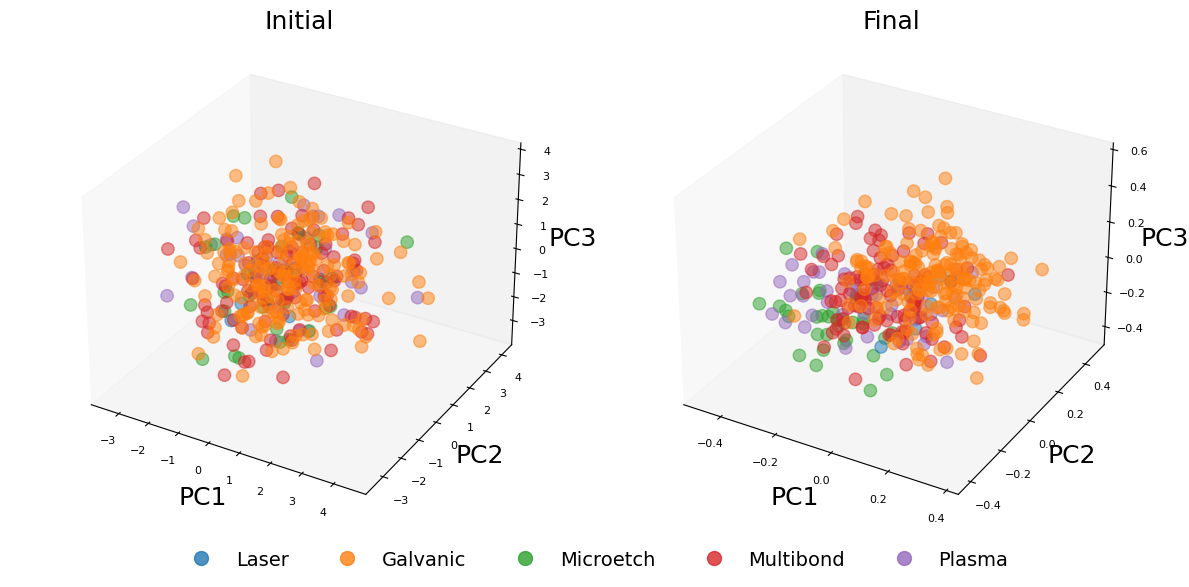

In [74]:
plot_pca_3d_pair(df_var_init,df_var, title_left="Initial", title_right="Final",hue_col="process", save_dir="./figures")